In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# packing and unpacking images
def packcw(A,nr,nc):
    x = (A.T).reshape(nr*nc,1)
    return x

def unpackcw(x,nr,nc):
    A = x.reshape(nc,nr)
    return A.T

def packrw(A,nr,nc):
    x = A.reshape(nr*nc,1)
    return x

def unpackrw(x,nr,nc):
    A = x.reshape(nr,nc)
    return A

# generates a 784 element mask with columns deleted
# from the right side of the image towards the left
def generateColumnMask(delColumns):
    mask = np.ones((28, 28))
    mask[:, (28 - delColumns):] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# generate a 784 element mask with a square, with side
# length (sideLength), zero'd out of the middle
def generateCenterSquareMask(sideLength):
    mask = np.ones((28, 28))
    leftIdx = (28 - sideLength)/2
    rightIdx = (28 + sideLength)/2
    mask[leftIdx:rightIdx, leftIdx:rightIdx] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# zero out indices of a vector for a data matrix
# for a given mask
def hideData(data, mask):
    # copy the data
    newData = data.copy()
    
    # get indices from the mask
    x_idx = np.where([mask==1])[1]
    y_idx = np.where([mask==0])[1]
    
    # apply the mask
    newData[y_idx, :] = 0
    
    return newData, data[x_idx, :], data[y_idx, :]

# get statistics for mmse
def getStatistics(data, vectorMask):
    # get mean and covariance of original data
    mean = np.mean(data, axis=1)
    cov = np.cov(data)
    
    # get indices for X, Y parts of data
    x_idx = np.where([vectorMask == 1])[1]
    y_idx = np.where([vectorMask == 0])[1]
        
    # apply masks
    u_x = mean[x_idx]
    u_y = mean[y_idx]
    cov_x = cov[x_idx]
    cov_x = cov_x[:, x_idx]
    cov_yx = cov[y_idx]
    cov_yx = cov_yx[:, x_idx]
    cov_y = cov[y_idx]
    cov_y = cov_y[:, y_idx]
    
    # return statistics
    return u_x, u_y, cov_x, cov_yx

# let's get the data for halves
def returnHalfData(ncols):
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    '''
    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)
    '''

    train_hideRight, Xtrain_hideRight, Ytrain_hideRight = hideData(train, generateColumnMask(ncols))
    test_hideRight, Xtest_hideRight, Ytest_hideRight = hideData(test, generateColumnMask(ncols))

    return train_hideRight, Xtrain_hideRight, Ytrain_hideRight, test_hideRight, Xtest_hideRight, Ytest_hideRight

# let's get the data for halves
def returnSquareData(squareSideLength):
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    '''
    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)
    '''
    
    train_hideMiddle, Xtrain_hideMiddle, Ytrain_hideMiddle = hideData(train, generateCenterSquareMask(squareSideLength))
    test_hideMiddle, Xtest_hideMiddle, Ytest_hideMiddle = hideData(test, generateCenterSquareMask(squareSideLength))

    return train_hideMiddle, Xtrain_hideMiddle, Ytrain_hideMiddle, test_hideMiddle, Xtest_hideMiddle, Ytest_hideMiddle

# let's get the data
def returnData():
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    return train, test


In [2]:
def Wstar(cov_x, cov_yx):
    if cov_x.any():
        cov_x_inv = np.linalg.pinv(cov_x)
    else:
        cov_x_inv = cov_x
    W = np.dot(cov_yx, cov_x_inv)
    return W

def mmseEstimator(x, u_x, u_y, cov_x, cov_yx):
    W = Wstar(cov_x, cov_yx)
    dist = x - u_x.reshape((u_x.shape[0]), 1)
    return np.dot(W, dist) + u_y.reshape((u_y.shape[0]), 1)

In [5]:
train, test = returnData()

----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000


In [6]:
# -------------------------------------------------------------
#  Removing Different Number of Columns with MMSE estimator
# -------------------------------------------------------------

train_colMSEs = np.zeros(28)
test_colMSEs = np.zeros(28)

for i in range(28):
    nCols = (i+1)
    vecMask = generateColumnMask(nCols)
        
    train_hideRight, Xtrain_hideRight, Ytrain_hideRight, \
    test_hideRight, Xtest_hideRight, Ytest_hideRight = returnHalfData(nCols)
    
    u_x, u_y, cov_x, cov_yx = getStatistics(train, vecMask)
    Ytrain_hideRight_hat = mmseEstimator(Xtrain_hideRight, u_x, u_y, cov_x, cov_yx)
    Ytest_hideRight_hat = mmseEstimator(Xtest_hideRight, u_x, u_y, cov_x, cov_yx)
    
    diff_train = Ytrain_hideRight - Ytrain_hideRight_hat
    trainMSEs = np.zeros(10000)
    for j in range(10000):
        trainMSEs[j] = np.mean(np.multiply(diff_train[:, j], diff_train[:, j]))
    train_colMSEs[i] = np.mean(trainMSEs)

    diff_test = Ytest_hideRight - Ytest_hideRight_hat
    testMSEs = np.zeros(1000)
    for j in range(1000):
        testMSEs[j] = np.mean(np.multiply(diff_test[:, j], diff_test[:, j]))
    test_colMSEs[i] = np.mean(testMSEs)

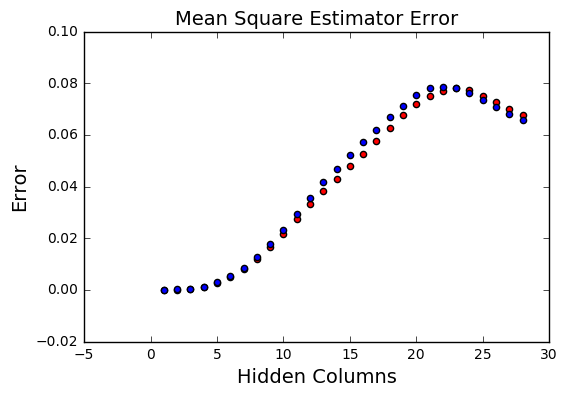

[  1.39669621e-05   1.11349200e-04   4.34285547e-04   1.21245663e-03
   2.71365264e-03   5.04312280e-03   8.13673464e-03   1.19679965e-02
   1.64509484e-02   2.16537029e-02   2.74809687e-02   3.31518034e-02
   3.82632554e-02   4.30648013e-02   4.78975335e-02   5.26703041e-02
   5.75176574e-02   6.27099067e-02   6.76222170e-02   7.17624726e-02
   7.50415300e-02   7.70809990e-02   7.80608091e-02   7.72608864e-02
   7.51651505e-02   7.26177336e-02   7.00135761e-02   6.75210808e-02]
[  4.07370995e-05   1.43425297e-04   4.69495445e-04   1.24779443e-03
   2.84890284e-03   5.32241386e-03   8.53820014e-03   1.25567842e-02
   1.75687615e-02   2.31680817e-02   2.95210766e-02   3.56241626e-02
   4.16047050e-02   4.68837833e-02   5.23039904e-02   5.71204388e-02
   6.19485959e-02   6.67584361e-02   7.13113315e-02   7.55176991e-02
   7.80227490e-02   7.85520010e-02   7.81629249e-02   7.60604684e-02
   7.33610273e-02   7.06890561e-02   6.80104467e-02   6.55828487e-02]


In [7]:
# plot mse 
plt.figure(1)
plt.scatter(np.arange(1,29), train_colMSEs, c='r')
plt.scatter(np.arange(1,29), test_colMSEs, c='b')
plt.title("Mean Square Estimator Error", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.xlabel("Hidden Columns", fontsize=14)
plt.show()

print train_colMSEs
print test_colMSEs

In [8]:
# --------------------------------------------------------
#  Removing Different Sized Squares with MMSE estimator
# --------------------------------------------------------
train_squareMSEs = np.zeros(14)
test_squareMSEs = np.zeros(14)

for i in range(14):
    squareSize = (i+1)*2
    vecMask = generateCenterSquareMask(squareSize)
    
    train_hideCenter, Xtrain_hideCenter, Ytrain_hideCenter, \
    test_hideCenter, Xtest_hideCenter, Ytest_hideCenter = returnSquareData(squareSize)
    
    u_x, u_y, cov_x, cov_yx = getStatistics(train, vecMask)
    Ytrain_hat_hideCenter = mmseEstimator(Xtrain_hideCenter, u_x, u_y, cov_x, cov_yx)
    Ytest_hat_hideCenter = mmseEstimator(Xtest_hideCenter, u_x, u_y, cov_x, cov_yx)
    
    diff_train = Ytrain_hideCenter - Ytrain_hat_hideCenter
    trainMSEs = np.zeros(10000)
    for j in range(10000):
        trainMSEs[j] = np.mean(np.multiply(diff_train[:, j], diff_train[:, j]))
    train_squareMSEs[i] = np.mean(trainMSEs)

    diff_test = Ytest_hideCenter - Ytest_hat_hideCenter
    testMSEs = np.zeros(1000)
    for j in range(1000):
        testMSEs[j] = np.mean(np.multiply(diff_test[:, j], diff_test[:, j]))
    test_squareMSEs[i] = np.mean(testMSEs)

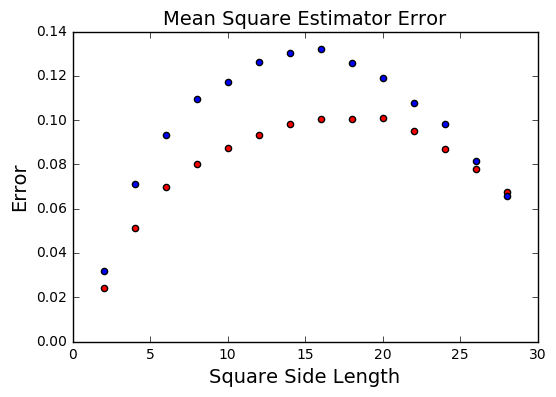

[ 0.02415308  0.05114388  0.06988564  0.08024208  0.08728272  0.09312629
  0.09803643  0.1003484   0.10058864  0.10114657  0.09492837  0.08707787
  0.07768026  0.06752108]
[ 0.03178387  0.07095345  0.09311441  0.10973924  0.11738725  0.12608947
  0.13051252  0.1320572   0.12582779  0.11902688  0.10760543  0.09823191
  0.08141908  0.06558285]


In [9]:
# plot mse 
plt.figure(1)
plt.scatter(np.arange(2,30,2), train_squareMSEs, c='r')
plt.scatter(np.arange(2,30,2), test_squareMSEs, c='b')
plt.title("Mean Square Estimator Error", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.xlabel("Square Side Length", fontsize=14)
plt.show()

print train_squareMSEs
print test_squareMSEs

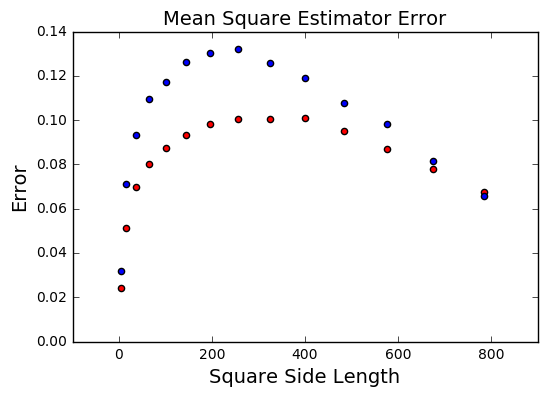

In [10]:
# plot mse 
plt.figure(1)
squareAreas = np.multiply(np.arange(2,30,2),np.arange(2,30,2))
plt.scatter(squareAreas, train_squareMSEs, c='r')
plt.scatter(squareAreas, test_squareMSEs, c='b')
plt.title("Mean Square Estimator Error", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.xlabel("Square Side Length", fontsize=14)
plt.show()